Drawn from https://www.statsmodels.org/dev/examples/notebooks/generated/glm_formula.html.

In [1]:
# Summon libraries.
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib
import scipy
import numpy as np

Call data.

In [2]:
# Call data. Uses PANDAS.
QI = pd.read_csv('./data/Exercise2.2Data.csv')
QI['score'] = QI['score']/100
QI.head()

,desgn,wrkyrs,priorQI,score
0,nurse,16,yes,0.63
1,nurse,9,yes,0.93
2,nurse,8,yes,0.74
3,nurse,1,no,0.69
4,nurse,5,no,0.67


Normality.
https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

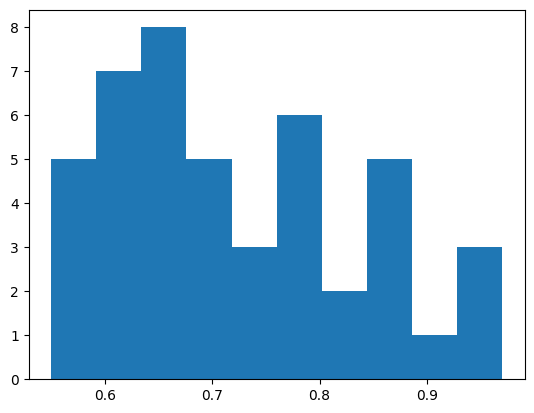

Anderson-Darling test statistic: 0.881
Shapiro-Wilks test statistic: 0.944 
Shapiro-Wilks p-value: 0.029


In [3]:
# Sets the y-value to the y-value[name] for normality tests.
y_val = QI["score"]

from matplotlib import pyplot
# Summon histogram. Uses matplotlib.
pyplot.hist(y_val)
pyplot.show()

# Uses scipy.stats for an Anderson-Darling test.
from scipy.stats import anderson
# Assign result from an Anderson-Darling test using the y-value.
result = anderson(y_val)
# Dump out result's test statistic.
print(f'Anderson-Darling test statistic: {result.statistic:.3f}')

# Uses scipy.stats for a Shapiro-Wilks test.
from scipy.stats import shapiro
# Assign results from a Shapiro-Wilks test using the y-value.
statistic, p_value = shapiro(y_val)
print(f"""Shapiro-Wilks test statistic: {statistic:.3f} 
Shapiro-Wilks p-value: {p_value:.3f}""")

Box-Cox. https://www.geeksforgeeks.org/box-cox-transformation-using-python/

Lambda is -0.9750167128694889
Anderson-Darling test statistic: 0.449
Shapiro-Wilks test statistic: 0.966 
Shapiro-Wilks p-value: 0.207


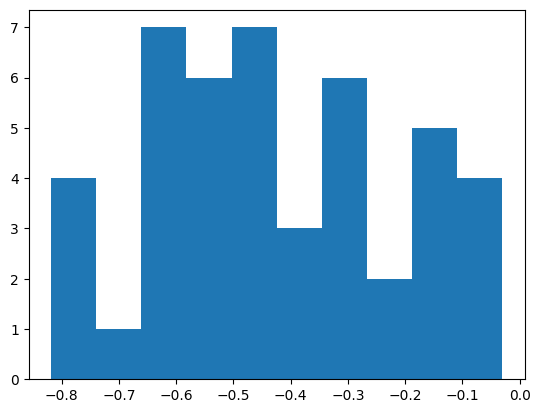

In [9]:
from scipy.stats import boxcox
QI['score_tr'], fitted_lambda = boxcox(QI['score'])
print(f'Lambda is {fitted_lambda}')

# for later usage
QI['score_tr_man'] = 1 - (1/QI['score'])
y_val = QI["score_tr_man"]

# Normality tests and histogram
result = anderson(y_val)
print(f'Anderson-Darling test statistic: {result.statistic:.3f}')
statistic, p_value = shapiro(y_val)
print(f"""Shapiro-Wilks test statistic: {statistic:.3f} 
Shapiro-Wilks p-value: {p_value:.3f}""")

pyplot.hist(y_val)
pyplot.show()


Develop models.

In [10]:
# Develop model.
QI['score_tr_man'] = 1 - (1/QI['score'])
formula = 'score_tr_man ~ C(desgn,Treatment("staff")) + wrkyrs + priorQI'
fitted = smf.glm(formula=formula, data=QI, family=sm.families.Gaussian()).fit()
print(fitted.summary())
fitloglike = (fitted.llf)
print(f'Sigma of fitted model is {np.sqrt(fitted.scale)}.')

                 Generalized Linear Model Regression Results                  
Dep. Variable:           score_tr_man   No. Observations:                   45
Model:                            GLM   Df Residuals:                       40
Model Family:                Gaussian   Df Model:                            4
Link Function:               Identity   Scale:                        0.043171
Method:                          IRLS   Log-Likelihood:                 9.5061
Date:                Tue, 24 Oct 2023   Deviance:                       1.7268
Time:                        00:26:22   Pearson chi2:                     1.73
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1497
Covariance Type:            nonrobust                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [6]:
# Null model.
formula = 'score_tr_man ~ 1'
null = smf.glm(formula=formula, data=QI, family=sm.families.Gaussian()).fit()
print(null.summary())
nullloglike = (null.llf)

                 Generalized Linear Model Regression Results                  
Dep. Variable:           score_tr_man   No. Observations:                   45
Model:                            GLM   Df Residuals:                       44
Model Family:                Gaussian   Df Model:                            0
Link Function:               Identity   Scale:                        0.046114
Method:                          IRLS   Log-Likelihood:                 5.8777
Date:                Tue, 24 Oct 2023   Deviance:                       2.0290
Time:                        00:25:34   Pearson chi2:                     2.03
No. Iterations:                     3   Pseudo R-squ. (CS):          0.0002506
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4191      0.032    -13.091      0.0

Log likelihood. Found the names through dir() https://stackoverflow.com/questions/2675028/list-attributes-of-an-object.

In [11]:
# Uses null and fitted log likelihoods to perform the deviance test.
deviance= -2 * (nullloglike-(fitloglike))
print(f"Deviance statistic is {deviance}.")
# Chi2.cdf is from scipy.stats.
from scipy.stats import chi2
pvalue = 1 - chi2.cdf(deviance,4)
print(f"p-value is {pvalue}.")

Deviance statistic is 7.256887290898154.
p-value is 0.12291982326181128.


Prediction. https://www.statology.org/statsmodels-predict/

In [12]:
# Prediction.
predict_val = pd.DataFrame(
    {"desgn": "nurse", "priorQI":"yes", "wrkyrs":7}, index=[0])
predict_val = sm.add_constant(predict_val)
100/(1-fitted.predict(predict_val))

# Simpler.
print(f'Predicted: {100/(1-fitted.predict(predict_val))}')

# Isolated. This one grabs the item "values" from the array.
print(f'Predicted: {100/(1-fitted.predict(predict_val)).values[0]}')

Predicted: 0    75.865283
dtype: float64
Predicted: 75.86528307041931
